In [2]:
!pip install pyspark

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, sum as _sum, count, desc
import pandas as pd
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("Retail-Capstone").getOrCreate()
sc = spark.sparkContext

In [4]:
customers_data = [
    (1, "Rahul Sharma", "Bangalore", 28),
    (2, "Priya Singh", "Delhi", 32),
    (3, "Aman Kumar", "Hyderabad", 25),
    (4, "Sneha Reddy", "Chennai", 35),
    (5, "Arjun Mehta", "Mumbai", 30),
    (6, "Divya Nair", "Delhi", 29)
]
customers_cols = ["customer_id", "name", "city", "age"]
customers_df = spark.createDataFrame(customers_data, customers_cols)

products_data = [
    (101, "Laptop", "Electronics", 55000),
    (102, "Mobile", "Electronics", 25000),
    (103, "Headphones", "Electronics", 3000),
    (104, "Chair", "Furniture", 5000),
    (105, "Book", "Stationery", 700),
    (106, "Shoes", "Fashion", 2500)
]
products_cols = ["product_id", "product_name", "category", "price"]
products_df = spark.createDataFrame(products_data, products_cols)

orders_data = [
    (1001, 1, 101, 1, "2024-01-10"),
    (1002, 2, 102, 2, "2024-01-12"),
    (1003, 1, 103, 3, "2024-02-05"),
    (1004, 3, 104, 1, "2024-02-08"),
    (1005, 5, 105, 5, "2024-03-01"),
    (1006, 6, 106, 2, "2024-03-15"),
    (1007, 7, 101, 1, "2024-03-20")  # invalid customer
]
orders_cols = ["order_id", "customer_id", "product_id", "quantity", "order_date"]
orders_df = spark.createDataFrame(orders_data, orders_cols)

In [6]:
nums = sc.parallelize([10, 20, 30, 40, 50])
print("Sum:", nums.reduce(lambda x,y: x+y))
print("Max:", nums.max())
print("Min:", nums.min())
print("Avg:", nums.mean())

Sum: 150
Max: 50
Min: 10
Avg: 30.0


In [8]:
sentences = sc.parallelize(["Hello world", "Hello Spark", "Spark with Python"])
words = sentences.flatMap(lambda s: s.split(" "))
word_count = words.map(lambda w: (w,1)).reduceByKey(lambda a,b:a+b)
print("Word Count:", word_count.collect())

Word Count: [('world', 1), ('with', 1), ('Python', 1), ('Hello', 2), ('Spark', 2)]


In [10]:
customers_df.select("name","city").show()

+------------+---------+
|        name|     city|
+------------+---------+
|Rahul Sharma|Bangalore|
| Priya Singh|    Delhi|
|  Aman Kumar|Hyderabad|
| Sneha Reddy|  Chennai|
| Arjun Mehta|   Mumbai|
|  Divya Nair|    Delhi|
+------------+---------+



In [12]:
customers_df.filter(col("age")>30).show()

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          2|Priya Singh|  Delhi| 32|
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+



In [14]:
products_df.orderBy(col("price").desc()).limit(3).show()

+----------+------------+-----------+-----+
|product_id|product_name|   category|price|
+----------+------------+-----------+-----+
|       101|      Laptop|Electronics|55000|
|       102|      Mobile|Electronics|25000|
|       104|       Chair|  Furniture| 5000|
+----------+------------+-----------+-----+



In [15]:
customers_df.groupBy("city").agg(avg("age").alias("avg_age")).show()

+---------+-------+
|     city|avg_age|
+---------+-------+
|Bangalore|   28.0|
|    Delhi|   30.5|
|Hyderabad|   25.0|
|  Chennai|   35.0|
|   Mumbai|   30.0|
+---------+-------+



In [16]:
orders_df.join(products_df,"product_id")\
    .groupBy("product_id","product_name")\
    .agg((_sum(col("quantity")*col("price"))).alias("total_revenue")).show()

+----------+------------+-------------+
|product_id|product_name|total_revenue|
+----------+------------+-------------+
|       101|      Laptop|       110000|
|       102|      Mobile|        50000|
|       103|  Headphones|         9000|
|       104|       Chair|         5000|
|       105|        Book|         3500|
|       106|       Shoes|         5000|
+----------+------------+-------------+



In [17]:
orders_df.groupBy("product_id").agg(_sum("quantity").alias("total_qty"))\
    .orderBy(desc("total_qty")).limit(1).show()


+----------+---------+
|product_id|total_qty|
+----------+---------+
|       105|        5|
+----------+---------+



In [18]:
orders_df.join(customers_df,"customer_id","inner").show()

+-----------+--------+----------+--------+----------+------------+---------+---+
|customer_id|order_id|product_id|quantity|order_date|        name|     city|age|
+-----------+--------+----------+--------+----------+------------+---------+---+
|          1|    1001|       101|       1|2024-01-10|Rahul Sharma|Bangalore| 28|
|          1|    1003|       103|       3|2024-02-05|Rahul Sharma|Bangalore| 28|
|          2|    1002|       102|       2|2024-01-12| Priya Singh|    Delhi| 32|
|          3|    1004|       104|       1|2024-02-08|  Aman Kumar|Hyderabad| 25|
|          5|    1005|       105|       5|2024-03-01| Arjun Mehta|   Mumbai| 30|
|          6|    1006|       106|       2|2024-03-15|  Divya Nair|    Delhi| 29|
+-----------+--------+----------+--------+----------+------------+---------+---+



In [19]:
orders_df.join(products_df,"product_id").select("order_id","product_name","category").show()

+--------+------------+-----------+
|order_id|product_name|   category|
+--------+------------+-----------+
|    1001|      Laptop|Electronics|
|    1007|      Laptop|Electronics|
|    1002|      Mobile|Electronics|
|    1003|  Headphones|Electronics|
|    1004|       Chair|  Furniture|
|    1005|        Book| Stationery|
|    1006|       Shoes|    Fashion|
+--------+------------+-----------+



In [20]:
customers_df.join(orders_df,"customer_id","left_anti").show()

+-----------+-----------+-------+---+
|customer_id|       name|   city|age|
+-----------+-----------+-------+---+
|          4|Sneha Reddy|Chennai| 35|
+-----------+-----------+-------+---+



In [21]:
products_df.join(orders_df,"product_id","left_anti").show()

+----------+------------+--------+-----+
|product_id|product_name|category|price|
+----------+------------+--------+-----+
+----------+------------+--------+-----+



In [22]:
customers_df.createOrReplaceTempView("customers")
products_df.createOrReplaceTempView("products")
orders_df.createOrReplaceTempView("orders")

In [23]:
spark.sql("""
SELECT c.city, SUM(o.quantity*p.price) as revenue
FROM orders o JOIN customers c ON o.customer_id=c.customer_id
JOIN products p ON o.product_id=p.product_id
GROUP BY c.city ORDER BY revenue DESC LIMIT 2
""").show()

+---------+-------+
|     city|revenue|
+---------+-------+
|Bangalore|  64000|
|    Delhi|  55000|
+---------+-------+



In [24]:
spark.sql("""
SELECT c.name, SUM(o.quantity*p.price) as total_spent
FROM orders o JOIN customers c ON o.customer_id=c.customer_id
JOIN products p ON o.product_id=p.product_id
GROUP BY c.name HAVING total_spent>50000
""").show()

+------------+-----------+
|        name|total_spent|
+------------+-----------+
|Rahul Sharma|      64000|
+------------+-----------+



In [25]:
spark.sql("""
SELECT p.category, SUM(o.quantity*p.price) as revenue
FROM orders o JOIN products p ON o.product_id=p.product_id
GROUP BY p.category ORDER BY revenue DESC LIMIT 1
""").show()

+-----------+-------+
|   category|revenue|
+-----------+-------+
|Electronics| 169000|
+-----------+-------+



In [26]:
orders_df.write.mode("overwrite").csv("orders_csv", header=True)
orders_csv = spark.read.csv("orders_csv", header=True, inferSchema=True)
orders_csv.show()

+--------+-----------+----------+--------+----------+
|order_id|customer_id|product_id|quantity|order_date|
+--------+-----------+----------+--------+----------+
|    1004|          3|       104|       1|2024-02-08|
|    1005|          5|       105|       5|2024-03-01|
|    1006|          6|       106|       2|2024-03-15|
|    1007|          7|       101|       1|2024-03-20|
|    1001|          1|       101|       1|2024-01-10|
|    1002|          2|       102|       2|2024-01-12|
|    1003|          1|       103|       3|2024-02-05|
+--------+-----------+----------+--------+----------+



In [27]:
products_df.write.mode("overwrite").json("products_json")
products_json = spark.read.json("products_json")
products_json.show()

+-----------+-----+----------+------------+
|   category|price|product_id|product_name|
+-----------+-----+----------+------------+
|Electronics|55000|       101|      Laptop|
|Electronics|25000|       102|      Mobile|
|Electronics| 3000|       103|  Headphones|
|  Furniture| 5000|       104|       Chair|
| Stationery|  700|       105|        Book|
|    Fashion| 2500|       106|       Shoes|
+-----------+-----+----------+------------+



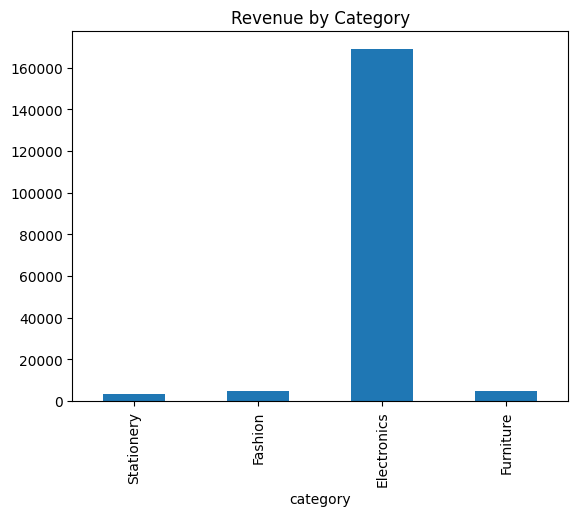

In [29]:
rev_cat = orders_df.join(products_df,"product_id")\
    .groupBy("category")\
    .agg((_sum(col("quantity")*col("price"))).alias("revenue"))\
    .toPandas()
rev_cat.plot(x="category", y="revenue", kind="bar", legend=False, title="Revenue by Category")
plt.show()

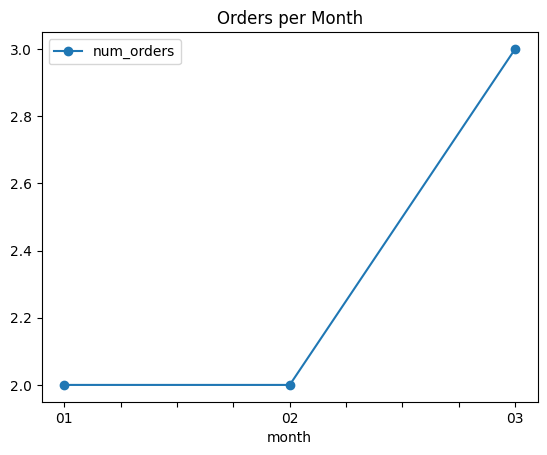

In [30]:
orders_month = orders_df.withColumn("month", col("order_date").substr(6,2))\
    .groupBy("month").agg(count("order_id").alias("num_orders"))\
    .orderBy("month").toPandas()
orders_month.plot(x="month", y="num_orders", kind="line", marker="o", title="Orders per Month")
plt.show()

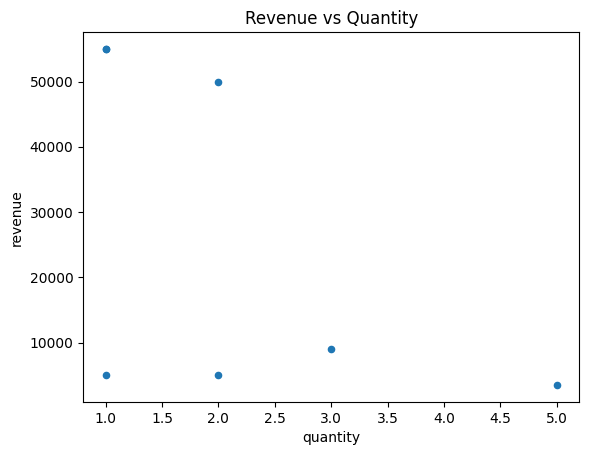

In [31]:
rev_qty = orders_df.join(products_df,"product_id")\
    .withColumn("revenue", col("quantity")*col("price"))\
    .select("quantity","revenue").toPandas()
rev_qty.plot.scatter(x="quantity", y="revenue", title="Revenue vs Quantity")
plt.show()